In [9]:
from Agent import Agent
from Game import SnakeGameAI
from helper import plot

MODEL_NAME = 'dqn_model_curriculum.pth'

<Figure size 432x288 with 0 Axes>

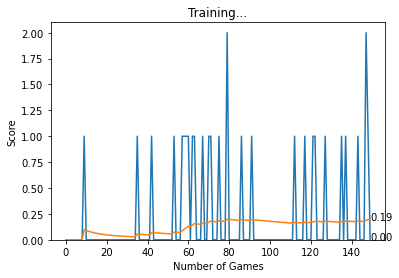

In [10]:
# using new obserations

plot_scores = []
plot_mean_scores = []
total_score = 0
record = 0
epsilons = []
game = SnakeGameAI(width=120, height=120, window_title="DQN - obs2")
agent = Agent(double_dqn=False, game=game)

episode = 0
NUM_EPISODES = 150
while episode < NUM_EPISODES:
    state = agent.get_observation()
    action = agent.choose_action(state)
    reward, done, score = agent.game.play_step(action)
    new_state = agent.get_observation()
    # remember
    agent.remember(state, action, reward, new_state, done)
            
    if done:
        episode += 1
        # train long memory, plot result
        agent.game.reset()
        
        states, actions, rewards, new_states, dones = agent.get_memory_sample()
        agent.learn(states, actions, rewards, new_states, dones)

        if score > record:
            record = score
            agent.save_model(MODEL_NAME)

        

        plot_scores.append(score)
        total_score += score
        mean_score = total_score / agent.number_episodes
        plot_mean_scores.append(mean_score)
        #print('Game', agent.n_games, 'Score', score, 'Record:', record, 'Mean Score: ', mean_score)
        plot(plot_scores,plot_mean_scores)


In [11]:
agent.save_model(MODEL_NAME)

<Figure size 432x288 with 0 Axes>

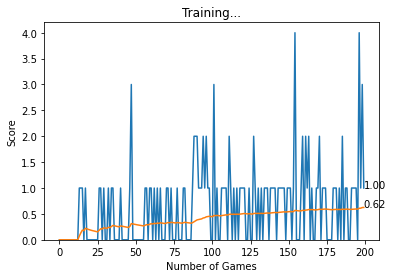

In [12]:
# using new obserations

plot_scores = []
plot_mean_scores = []
total_score = 0
record = 0
epsilons = []
game = SnakeGameAI(width=200, height=200, window_title="DQN - curriculum")
agent = Agent(double_dqn=False, game=game)
agent.load_model(MODEL_NAME)

episode = 0
NUM_EPISODES = 200
while episode < NUM_EPISODES:
    state = agent.get_observation()
    action = agent.choose_action(state)
    reward, done, score = agent.game.play_step(action)
    new_state = agent.get_observation()
    # remember
    agent.remember(state, action, reward, new_state, done)
            
    if done:
        episode += 1
        # train long memory, plot result
        agent.game.reset()
        
        states, actions, rewards, new_states, dones = agent.get_memory_sample()
        agent.learn(states, actions, rewards, new_states, dones)

        if score > record:
            record = score
            agent.save_model(MODEL_NAME)

        

        plot_scores.append(score)
        total_score += score
        mean_score = total_score / agent.number_episodes
        plot_mean_scores.append(mean_score)
        #print('Game', agent.n_games, 'Score', score, 'Record:', record, 'Mean Score: ', mean_score)
        plot(plot_scores,plot_mean_scores)


In [13]:
agent.save_model(MODEL_NAME)

<Figure size 432x288 with 0 Axes>

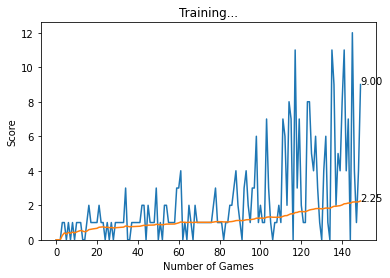

In [14]:

plot_scores = []
plot_mean_scores = []
total_score = 0
record = 0
epsilons = []
game = SnakeGameAI(window_title="DQN - curriculum - test")
agent_target = Agent(double_dqn=False, greedy=True, game=game)
agent_target.load_model(MODEL_NAME)

episode = 0
NUM_EPISODES = 150

while episode < NUM_EPISODES:
    state = agent_target.get_observation()
    action = agent_target.choose_action(state)
    reward, done, score = agent_target.game.play_step(action)
    new_state = agent_target.get_observation()
    # remember
    agent_target.remember(state, action, reward, new_state, done)
            
    if done:
        episode += 1
        # train long memory, plot result
        agent_target.game.reset()
        
        states, actions, rewards, new_states, dones = agent_target.get_memory_sample()
        agent_target.learn(states, actions, rewards, new_states, dones)

        if score > record:
            record = score

        

        plot_scores.append(score)
        total_score += score
        mean_score = total_score / agent_target.number_episodes
        plot_mean_scores.append(mean_score)
        #print('Game', agent_target.n_games, 'Score', score, 'Record:', record, 'Mean Score: ', mean_score)
        plot(plot_scores,plot_mean_scores)

In [15]:
agent_target.save_model(MODEL_NAME)

<Figure size 432x288 with 0 Axes>

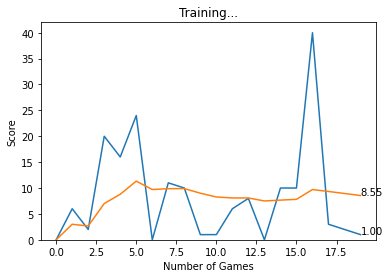

In [16]:
plot_scores = []
plot_mean_scores = []
total_score = 0
record = 0
epsilons = []
game = SnakeGameAI(window_title="DQN - curriculum - test")
agent_target = Agent(double_dqn=False, greedy=False, game=game)
agent_target.load_model(MODEL_NAME)

episode = 0
NUM_EPISODES = 20

while episode < NUM_EPISODES:
    state = agent_target.get_observation()
    action = agent_target.choose_action(state)
    reward, done, score = agent_target.game.play_step(action)
    new_state = agent_target.get_observation()
    # remember
    agent_target.remember(state, action, reward, new_state, done)
            
    if done:
        episode += 1
        # train long memory, plot result
        agent_target.game.reset()
        
        states, actions, rewards, new_states, dones = agent_target.get_memory_sample()
        agent_target.learn(states, actions, rewards, new_states, dones)

        if score > record:
            record = score

        

        plot_scores.append(score)
        total_score += score
        mean_score = total_score / agent_target.number_episodes
        plot_mean_scores.append(mean_score)
        #print('Game', agent_target.n_games, 'Score', score, 'Record:', record, 'Mean Score: ', mean_score)
        plot(plot_scores,plot_mean_scores)